# CS 109A Data Science: Project
**Harvard University**<br>
**Fall 2016**<br>
**Team member:** Becerra, Fernando; Mayo, Andrew Wayne; Ding, Yi; Cao, Xinrui<br>
**Project topic:** Predicting Seizures and Epilepsy

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import time
from scipy.stats import mode
from sklearn import linear_model
import sklearn.linear_model as sk
import matplotlib
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
import sklearn.discriminant_analysis as da
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

# Cleaning

In [2]:
# Read in data set UKDA-2024-tab
UKDA16 = pd.read_table('./datasets/NCDS/ncds0123.tab')

/Users/dilys/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (1,2,3,4,5,1756,1757,1758,1759,1760,1761,1762,1763,1764) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#sweep 1
# reason for special education
a = (UKDA16['n390'] =='10') | (UKDA16['n391'] =='10') | (UKDA16['n392'] =='10')
# Epileptic condition
b = (UKDA16['n415'] =='3') | (UKDA16['n415'] =='4')| (UKDA16['n415'] =='5') | (UKDA16['n415'] =='6')
# Fit or convulsion in 1st year of life
c = (UKDA16['n274'] == '2')
# Fit or convulsion after 1st year
d = (UKDA16['n275'] == '2')
# Epilepsy identification
e = (UKDA16['n1842']=='5')
s1 =a|b|c|d|e

In [4]:
# sweep 2
# Has child had epilepsy attacks
a = (UKDA16['n1307']=='1')|(UKDA16['n1307']=='2')|(UKDA16['n1307']=='3')|(UKDA16['n1307']=='4')|(UKDA16['n1307']=='5')
# Age at most recent epilepsy attack
UKDA16['n1314']
# Age at 1st epilepsy attack
UKDA16['n1317']
# Reason for special education
b = (UKDA16['n1477'] =='7') | (UKDA16['n1478'] =='7') | (UKDA16['n1479'] =='7')
# Reason for absence from school
c = (UKDA16['n1321']=='8') |(UKDA16['n1322']=='8')|(UKDA16['n1323']=='8')|(UKDA16['n1324']=='8')|(UKDA16['n1325']=='8') 
# Reason for prescription
d = (UKDA16['n1337']=='1') |(UKDA16['n1338']=='1')
# Ever seen specialist-convulsions,fits
e = (UKDA16['n1394']=='2')|(UKDA16['n1394']=='3')|(UKDA16['n1394']=='5')
# Has child ever had convulsions
f = (UKDA16['n1502'] =='2')| (UKDA16['n1502'] =='3')|(UKDA16['n1502'] =='4')
s2 = a|b|c|d|e
s1s2 =s1|s2

In [5]:
# sweep 3
# Type hcap for which will require help
a = (UKDA16['n2416'] =='7')
# Nature of child-s disability-
b = (UKDA16['n2663'] =='7')|(UKDA16['n2664'] =='7')|(UKDA16['n2665'] =='7')|(UKDA16['n2666'] =='7')|(UKDA16['n2667'] =='7')
# Category of child's handicap
c = (UKDA16['n1893'] =='8')|(UKDA16['n1894'] =='8')|(UKDA16['n1895'] =='8')
# Reason for hosp admiss last 12 mnths
d = (UKDA16['n1904'] =='17')
# Reason hosp outpatient last yr
e = (UKDA16['n1910'] =='17')
# Epilepsy
#f = (UKDA16['n2032'] =='17')
# Reason for absence from school
g = (UKDA16['n2554'] =='11')|(UKDA16['n2556'] =='11')|(UKDA16['n2557'] =='11')|(UKDA16['n2558'] =='11')|(UKDA16['n2559'] =='11')
# Hospital admissions
h = (UKDA16['n2598'] =='7') | (UKDA16['n2599'] =='7') | (UKDA16['n2600'] =='7') | (UKDA16['n2601'] =='7') 
# Hosp outpatient,diagnosed cond
j = (UKDA16['n2603'] =='10')|(UKDA16['n2604'] =='10')|(UKDA16['n2605'] =='10')|(UKDA16['n2606'] =='10')|(UKDA16['n2607'] =='10')|(UKDA16['n2608'] =='10')
# Convulsions,fits-unconsciousness
k = (UKDA16['n2614'] =='1')
# When convulsions,fits 1st occured
(UKDA16['n2615'] =='5')|(UKDA16['n2615'] =='5')
# Convulsions-most recent occurrence
l = (UKDA16['n2616'] =='1')|(UKDA16['n2616'] =='2')|(UKDA16['n2616'] =='3')|(UKDA16['n2616'] =='4')
s3 = d|e|g|h|j|l

- From Sweep 1 and Sweep 2, we extract all children who had any sign of epilepsy and convulsion. 
- From Sweep 3, we extract all children who had any sign of epilepsy and convulsion after age 11 (eg. hospitalization for convulsion or epilepsy, recent occurence of convulsion within 7 years)
- We take the join of s1s2 and s3, which include all children who have sign of epilepsy before 11 and had recurrence after 11.

In [6]:
sum(s1s2)

1026

In [7]:
sum(s1s2 & s3)

250

- select social economic status and medical status variables from three sweep and combine

In [8]:
filename = "./datasets/NCDS/sweep1_new.txt"
s1_variable = []
for line in open(filename):
    if 'Pos.' in line:
        name = line.rstrip().replace("\t",' ').split(' ')[5]
        s1_variable.append(name)
        
print len(s1_variable)

126


In [9]:
filename = "./datasets/NCDS/sweep2_new.txt"
s2_variable = []
for line in open(filename):
    if 'Pos.' in line:
        name = line.rstrip().replace("\t",' ').split(' ')[5]
        s2_variable.append(name)
        
print len(s2_variable)

44


In [10]:
filename = "./datasets/NCDS/sweep3_new.txt"
s3_variable = []
for line in open(filename):
    if 'Pos.' in line:
        name = line.rstrip().replace("\t",' ').split(' ')[5]
        s3_variable.append(name)
        
print len(s3_variable)

37


In [11]:
variables = s1_variable + s2_variable + s3_variable

### Here comes our final dataset!

In [12]:
data = UKDA16[variables][s1s2]

- Count missing rate

In [13]:
a = (data=='-1').sum(axis =0)/1046
b = (data==' ').sum(axis =0)/1046
sum(a+b<0.5)

188

In [14]:
#drop data with >0.5 missing rate
data = data[list(data.columns[np.where(a+b<0.5)])]

# fill in the blanks as '-1'
for col in data.columns:
    value = data[col]
    missing_index = (value == ' ')
    data[col][missing_index] = '-1'

In [15]:
data = data.convert_objects(convert_numeric=True)
data.shape

/Users/dilys/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


(1026, 188)

In [16]:
# fill in the missing data
# randomly choose a value from the same colunm
for col in data.columns:
    value = data[col]
    if(len(np.unique(value))>20):
        missing_index = (value == -1)
        filled_index = (value != -1)
        data[col][missing_index] = np.mean(value[filled_index])

/Users/dilys/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
data_dummy=pd.DataFrame()

for i in data.columns:
    if len(np.unique(data[i]))<=20:
        data_dummy=pd.concat([data_dummy, pd.get_dummies(data[i])], axis=1)
    else:
        data_dummy=pd.concat([data_dummy, data[i]], axis=1)

data_dummy.shape

(1026, 1284)

In [18]:
# create response
y = np.zeros(len(UKDA16))
y = pd.DataFrame(y, index = UKDA16.index)
y[s1s2&s3] = 1
y = y[s1s2]
y = y.astype(int)

In [19]:
y = y[0] # This is required so that y has the right shape

# Model

Predictors are in `data`, response is in `y`


In [20]:
def calculate_model(x_train, y_train, x_test, y_test, x, model):
    model.fit(x_train, y_train)
    y_pred = model.predict(x)
    score_train = model.score(x_train, y_train)
    score_test = model.score(x_test, y_test)
    return score_train, score_test, y_pred

def print_info(title, train, test, cm):
    print '*** ' + title + ' ***'
    print 'Training score: %.3f, Testing score: %.3f' %(train.mean(), test.mean())
    print 'Non-relapse accuracy: %.3f, relapse accuracy: %.3f' %(float(cm[0, 0]) / cm[0].sum(), float(cm[1, 1]) / cm[1].sum())

In [21]:
def find_feature(position, index, features):
    n = len(features)
    for i in range(n-1):
        if position in range(index[i],index[i+1]):
            break
    return features[i]
    

In [22]:
index = [0]
i = 0
for col in data.columns:
    x = np.unique(data[col])
    if len(x)<=20:
        i = i+len(x)
    else:
        i = i+1
    index = index + [i]
    
features = list(data.columns)

find_feature(3, index, features)

'n0region'

## A broad view of all methods

In [23]:
n_iter = 10
n_rows = data_dummy.shape[0]
depths = range(1,3)
n_depths = len(depths)
#Cs = [0.1, 1, 10, 100]
#n_Cs = len(Cs)
C = 10

logreg_test = np.zeros(n_iter)
logreg_train = np.zeros(n_iter)
logreg_pred = np.zeros(n_rows)
dt_test = np.zeros((n_iter, n_depths))
dt_train = np.zeros((n_iter, n_depths))
dt_pred = np.zeros((n_rows, n_depths))
lda_test = np.zeros(n_iter)
lda_train = np.zeros(n_iter)
lda_pred = np.zeros(n_rows)
qda_test = np.zeros(n_iter)
qda_train = np.zeros(n_iter)
qda_pred = np.zeros(n_rows)
rf_test = np.zeros((n_iter, n_depths))
rf_train = np.zeros((n_iter, n_depths))
rf_pred = np.zeros((n_rows, n_depths))
svc_linear_test = np.zeros(n_iter)
svc_linear_train = np.zeros(n_iter)
svc_linear_pred = np.zeros(n_rows)
svc_quad_test = np.zeros(n_iter)
svc_quad_train = np.zeros(n_iter)
svc_quad_pred = np.zeros(n_rows)


for i in range(n_iter):

    print 'Iteration %i' %i

    x_train, x_test, y_train, y_test = train_test_split(data_dummy, y, train_size=0.6)

    logreg = LogisticRegression(C=1000)
    logreg_train[i], logreg_test[i], y_pred = calculate_model(x_train, y_train, x_test, y_test, data_dummy, logreg)
    logreg_pred += y_pred

    lda = LDA()
    lda_train[i], lda_test[i], y_pred = calculate_model(x_train, y_train, x_test, y_test, data_dummy, lda)
    lda_pred += y_pred

    qda = QDA()
    qda_train[i], qda_test[i], y_pred = calculate_model(x_train, y_train, x_test, y_test, data_dummy, qda)
    qda_pred += y_pred

    for depth in depths:

        dt = DecisionTree()
        dt_train[i, depth-1], dt_test[i, depth-1], y_pred = calculate_model(x_train, y_train, x_test, y_test, data_dummy, dt)
        dt_pred[:, depth-1] += y_pred

        rf = RandomForest()
        rf_train[i, depth-1], rf_test[i, depth-1], y_pred = calculate_model(x_train, y_train, x_test, y_test, data_dummy, rf)
        rf_pred[:, depth-1] += y_pred


    svc_linear = SVC(C=C, kernel='linear') #, class_weight=weights)
    svc_linear_train[i], svc_linear_test[i], y_pred = calculate_model(x_train, y_train, x_test, y_test, data_dummy, svc_linear)
    svc_linear_pred += y_pred 

    svc_quad = SVC(C=C, kernel='rbf') #, class_weight=weights)
    svc_quad_train[i], svc_quad_test[i], y_pred = calculate_model(x_train, y_train, x_test, y_test, data_dummy, svc_quad)
    svc_quad_pred += y_pred 

# Choose depth with maximum test score
dt_idx = np.argmax(dt_test.mean(axis=0))
rf_idx = np.argmax(rf_test.mean(axis=0))

# Choose C with maximum test score
svc_linear_idx = np.argmax(svc_linear_test.mean(axis=0))
svc_quad_idx = np.argmax(svc_quad_test.mean(axis=0))

# Take majority vote
logreg_pred = [1 if pred > n_iter/2. else 0 for pred in logreg_pred]
lda_pred = [1 if pred > n_iter/2. else 0 for pred in lda_pred]
qda_pred = [1 if pred > n_iter/2. else 0 for pred in qda_pred]
dt_pred = [1 if pred > n_iter/2. else 0 for pred in dt_pred[:, dt_idx]]
rf_pred = [1 if pred > n_iter/2. else 0 for pred in rf_pred[:, rf_idx]]
svc_linear_pred = [1 if pred > n_iter/2. else 0 for pred in svc_linear_pred]
svc_quad_pred = [1 if pred > n_iter/2. else 0 for pred in svc_quad_pred]

# Calculate accuracies
logreg_cm = confusion_matrix(y, logreg_pred)
lda_cm = confusion_matrix(y, lda_pred)
qda_cm = confusion_matrix(y, qda_pred)
dt_cm = confusion_matrix(y, dt_pred)
rf_cm = confusion_matrix(y, rf_pred)
svc_linear_cm = confusion_matrix(y, svc_linear_pred)
svc_quad_cm = confusion_matrix(y, svc_quad_pred)

print_info('LogReg', logreg_train, logreg_test, logreg_cm)
print_info('LDA', lda_train, lda_test, lda_cm)
print_info('QDA', qda_train, qda_test, qda_cm)
print_info('DT', dt_train[:, dt_idx], dt_test[:, dt_idx], dt_cm)
print 'Depth ', depths[dt_idx]
print_info('RF', rf_train[:, rf_idx], rf_test[:, rf_idx], rf_cm)
print 'Depth ', depths[rf_idx]
print_info('SVC linear', svc_linear_train, svc_linear_test, svc_linear_cm)
print_info('SVC quad', svc_quad_train, svc_quad_test, svc_quad_cm)

Iteration 0


/Users/dilys/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/dilys/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
*** LogReg ***
Training score: 1.000, Testing score: 0.685
Non-relapse accuracy: 0.991, relapse accuracy: 0.840
*** LDA ***
Training score: 0.984, Testing score: 0.634
Non-relapse accuracy: 0.991, relapse accuracy: 0.880
*** QDA ***
Training score: 1.000, Testing score: 0.655
Non-relapse accuracy: 1.000, relapse accuracy: 0.792
*** DT ***
Training score: 1.000, Testing score: 0.689
Non-relapse accuracy: 0.999, relapse accuracy: 0.916
Depth  2
*** RF ***
Training score: 0.978, Testing score: 0.735
Non-relapse accuracy: 1.000, relapse accuracy: 0.616
Depth  2
*** SVC linear ***
Training score: 1.000, Testing score: 0.683
Non-relapse accuracy: 0.991, relapse accuracy: 0.860
*** SVC quad ***
Training score: 0.958, Testing score: 0.723
Non-relapse accuracy: 0.995, relapse accuracy: 0.524


Non-relapse and relapse accuracies are based on the *whole* dataset -- It is basically a misclassification rate. To calculate the prediction we use a majority vote based on `n_iter = 10`, just like we did in previous homework. For the case of decision tree and random forest, we also calculate the optimal depth.

## optimize decision tree method

In [31]:
##KFold corss validation to determine optimal regular parameter
x_train, x_test, y_train, y_test = train_test_split(data_dummy, y, train_size=0.6)
from sklearn.cross_validation import KFold

y_cv = y_train
x_cv = x_train
y_cv.index = range(len(y_train))
x_cv.index = range(len(y_train))

score_train = np.zeros([100,5])
score_test = np.zeros([100,5])
accuracy_0 = np.zeros([100,5])
accuracy_1 = np.zeros([100,5])

score_K = np.zeros([100,4])

kf = KFold(len(y_cv),5, shuffle=True)
j=0 #index the jth fold

for train_idx, test_idx in kf:
    
    # get training and testing sets 
    y_train, x_train = y_cv.ix[train_idx, ], x_cv.ix[train_idx, ]
    y_test , x_test  = y_cv.ix[test_idx, ], x_cv.ix[test_idx, ]

    # fit Lasso regression with varying lambda
    for i in range(1,100):
        dt = DecisionTree(max_depth= i)
        dt.fit(x_train, y_train)
        score_train[i,j] = dt.score(x_train, y_train)
        score_test[i,j] = dt.score(x_test, y_test)
        accuracy_0[i,j] = dt.score(x_test[y_test==0], y_test[y_test==0])
        accuracy_1[i,j] = dt.score(x_test[y_test==1], y_test[y_test==1])
    
    # calculate r-squared mean across five fold for each lamda
    for i in range(1,100):
        score_K[i,0]=score_train[i,:].mean()
        score_K[i,1]=score_test[i,:].mean()
        score_K[i,2]=accuracy_0[i,:].mean()
        score_K[i,3]=accuracy_1[i,:].mean()
    
    j=j+1  

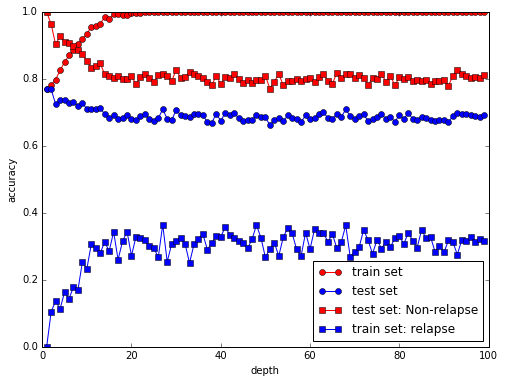

In [32]:
plt.figure(figsize=(8,6))
plt.plot(range(1,100),score_K[1:100,0],'ro-', label ='train set')          
plt.plot(range(1,100),score_K[1:100,1],'bo-', label ='test set') 
plt.plot(range(1,100),score_K[1:100,2],'rs-', label ='test set: Non-relapse') 
plt.plot(range(1,100),score_K[1:100,3],'bs-', label ='train set: relapse') 

plt.xlabel('depth')        
plt.ylabel('accuracy') 
plt.legend(loc = 'best')         

plt.show()

## balance dataset

In [82]:
x_train, x_test, y_train, y_test = train_test_split(data_dummy, y, train_size=0.7)

n=500
ind0 = np.random.choice(y_train[y_train==0].index, n, replace=True)
ind1 = np.random.choice(y_train[y_train==1].index, n, replace=True)
x_frames = [x_train.ix[ind0,], x_train.ix[ind1, ]]
x_train_sub = pd.concat(x_frames, axis = 0)
y_frames = [y_train[ind0], y_train[ind1]]
y_train_sub = pd.concat(y_frames, axis = 0)

In [83]:
pred_matrix = np.zeros((len(y_test),100))
importance_matrix = np.zeros((1284, 100))
for i in range(100):
    dt = DecisionTree(max_depth = 30)
    dt.fit(x_train_sub, y_train_sub)
    pred_matrix[:,i] = dt.predict(x_test)
    importance_matrix[:,i] = dt.feature_importances_

In [84]:
results = pred_matrix.mean(axis =1)
results[results > 0.5 ]=1
results[results < 0.5 ]=0
results[results ==0.5] = np.random.choice([0,1])
print('accuracy of non-relapse:')
print np.mean((results == y_test)[y_test ==0])
print('accuracy of relapse:')
print np.mean((results == y_test)[y_test ==1])

accuracy of non-relapse:
0.732456140351
accuracy of relapse:
0.4875


## get important features

In [85]:
importance = importance_matrix.mean(axis =1)
indices = np.argsort(importance)[::-1][0:20]

namelist = []
for ind in indices:
    name = find_feature(ind, index, features)
    namelist.append(name)
namelist

['n2531',
 'n510',
 'n183',
 'n2560',
 'n510',
 'n1229',
 'n1687',
 'n1008',
 'n142',
 'n974',
 'n2560',
 'n2385',
 'n1001',
 'n989',
 'n2504',
 'n182',
 'n519',
 'n518',
 'n136',
 'n977']

In [86]:
import plotly.plotly as py
import plotly.graph_objs as go

# non-relapse accuracy
trace0 = go.Bar(
    x=['LogReg', 'LDA', 'QDA', 'DT', 'RF', 'SVC linear','SVC quadratic'],
    y=[float(logreg_cm[0, 0]) / logreg_cm[0].sum(), float(lda_cm[0, 0]) / lda_cm[0].sum(),
      float(qda_cm[0, 0]) / qda_cm[0].sum(), float(dt_cm[0, 0]) / dt_cm[0].sum(),
      float(rf_cm[0, 0]) / rf_cm[0].sum(), float(svc_linear_cm[0, 0]) / svc_linear_cm[0].sum(),
      float(svc_quad_cm[0, 0]) / svc_quad_cm[0].sum()],
    name='Non-replase Accuracies',
    marker=dict(
        color='rgb(49,130,189)'
    )
)
# replase accuracy
trace1 = go.Bar(
    x=['LogReg', 'LDA', 'QDA', 'DT', 'RF', 'SVC linear','SVC quadratic'],
    y=[float(logreg_cm[1, 1]) / logreg_cm[1].sum(), float(lda_cm[1, 1]) / lda_cm[1].sum(),
      float(qda_cm[1, 1]) / qda_cm[1].sum(), float(dt_cm[1, 1]) / dt_cm[1].sum(),
      float(rf_cm[1, 1]) / rf_cm[1].sum(), float(svc_linear_cm[1, 1]) / svc_linear_cm[1].sum(),
      float(svc_quad_cm[1, 1]) / svc_quad_cm[1].sum()],
    name='Replase Accuracies',
    marker=dict(
        color='rgb(204,204,204)',
    )
)

data = [trace0, trace1]
layout = go.Layout(
    xaxis=dict(tickangle=-45),
    barmode='group',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='angled-text-bar')

PlotlyLocalCredentialsError: 
Couldn't find a 'username', 'api-key' pair for you on your local machine. To sign in temporarily (until you stop running Python), run:
>>> import plotly.plotly as py
>>> py.sign_in('username', 'api_key')

Even better, save your credentials permanently using the 'tools' module:
>>> import plotly.tools as tls
>>> tls.set_credentials_file(username='username', api_key='api-key')

For more help, see https://plot.ly/python.


In [ ]:
# Compute the feature importances for decision tree

forest = DecisionTree(max_depth = 10)
forest.fit(x_train, y_train)

importances = forest.feature_importances_

indices = np.argsort(importances)[::-1][0:20]
print indices
print importances[indices], importances[indices].shape

# Print the feature ranking
print("Feature ranking:")

#for f in range(x_train.shape[1]):
for f in range(20):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize = (10,5))
plt.title("Feature importances")

#Bar plot of the frequencies of the top words
plt.bar(range(20), importances[indices], color='red', alpha=0.5)

#Label the bars with the top words
plt.xticks(range(20), indices)
plt.show()

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go

trace0 = go.Bar(
    y= range(20),
    x= list(importances[indices]),
    text=list(namelist),
    marker=dict(
        color='rgb(158,202,225)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5,
        )
    ),
    orientation = 'h',
    opacity=0.6
)

data = [trace0]
layout = go.Layout(
    title='Feature importances',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar plot')

In [ ]:
n_iter = 10
n_rows = data.shape[0]
depths = range(1,3)
n_depths = len(depths)
#Cs = [0.1, 1, 10, 100]
#n_Cs = len(Cs)
C = 10

logreg_test = np.zeros(n_iter)
logreg_train = np.zeros(n_iter)
logreg_pred = np.zeros(n_rows)
dt_test = np.zeros((n_iter, n_depths))
dt_train = np.zeros((n_iter, n_depths))
dt_pred = np.zeros((n_rows, n_depths))
lda_test = np.zeros(n_iter)
lda_train = np.zeros(n_iter)
lda_pred = np.zeros(n_rows)
qda_test = np.zeros(n_iter)
qda_train = np.zeros(n_iter)
qda_pred = np.zeros(n_rows)
rf_test = np.zeros((n_iter, n_depths))
rf_train = np.zeros((n_iter, n_depths))
rf_pred = np.zeros((n_rows, n_depths))
svc_linear_test = np.zeros(n_iter)
svc_linear_train = np.zeros(n_iter)
svc_linear_pred = np.zeros(n_rows)
svc_quad_test = np.zeros(n_iter)
svc_quad_train = np.zeros(n_iter)
svc_quad_pred = np.zeros(n_rows)


for i in range(n_iter):

    print 'Iteration %i' %i

    x_train, x_test, y_train, y_test = train_test_split(data, y, train_size=0.6)

    logreg = LogisticRegression(C=1000)
    logreg_train[i], logreg_test[i], y_pred = calculate_model(x_train, y_train, x_test, y_test, data, logreg)
    logreg_pred += y_pred

    lda = LDA()
    lda_train[i], lda_test[i], y_pred = calculate_model(x_train, y_train, x_test, y_test, data, lda)
    lda_pred += y_pred

    qda = QDA()
    qda_train[i], qda_test[i], y_pred = calculate_model(x_train, y_train, x_test, y_test, data, qda)
    qda_pred += y_pred

    for depth in depths:

        dt = DecisionTree(max_depth = depth)
        dt_train[i, depth-1], dt_test[i, depth-1], y_pred = calculate_model(x_train, y_train, x_test, y_test, data, dt)
        dt_pred[:, depth-1] += y_pred

        rf = RandomForest(n_estimators=15, max_depth = depth)
        rf_train[i, depth-1], rf_test[i, depth-1], y_pred = calculate_model(x_train, y_train, x_test, y_test, data, rf)
        rf_pred[:, depth-1] += y_pred


    svc_linear = SVC(C=C, kernel='linear') #, class_weight=weights)
    svc_linear_train[i], svc_linear_test[i], y_pred = calculate_model(x_train, y_train, x_test, y_test, data, svc_linear)
    svc_linear_pred += y_pred 

    svc_quad = SVC(C=C, kernel='rbf') #, class_weight=weights)
    svc_quad_train[i], svc_quad_test[i], y_pred = calculate_model(x_train, y_train, x_test, y_test, data, svc_quad)
    svc_quad_pred += y_pred 

# Choose depth with maximum test score
dt_idx = np.argmax(dt_test.mean(axis=0))
rf_idx = np.argmax(rf_test.mean(axis=0))

# Choose C with maximum test score
svc_linear_idx = np.argmax(svc_linear_test.mean(axis=0))
svc_quad_idx = np.argmax(svc_quad_test.mean(axis=0))

# Take majority vote
logreg_pred = [1 if pred > n_iter/2. else 0 for pred in logreg_pred]
lda_pred = [1 if pred > n_iter/2. else 0 for pred in lda_pred]
qda_pred = [1 if pred > n_iter/2. else 0 for pred in qda_pred]
dt_pred = [1 if pred > n_iter/2. else 0 for pred in dt_pred[:, dt_idx]]
rf_pred = [1 if pred > n_iter/2. else 0 for pred in rf_pred[:, rf_idx]]
svc_linear_pred = [1 if pred > n_iter/2. else 0 for pred in svc_linear_pred]
svc_quad_pred = [1 if pred > n_iter/2. else 0 for pred in svc_quad_pred]

# Calculate accuracies
logreg_cm = confusion_matrix(y, logreg_pred)
lda_cm = confusion_matrix(y, lda_pred)
qda_cm = confusion_matrix(y, qda_pred)
dt_cm = confusion_matrix(y, dt_pred)
rf_cm = confusion_matrix(y, rf_pred)
svc_linear_cm = confusion_matrix(y, svc_linear_pred)
svc_quad_cm = confusion_matrix(y, svc_quad_pred)

print_info('LogReg', logreg_train, logreg_test, logreg_cm)
print_info('LDA', lda_train, lda_test, lda_cm)
print_info('QDA', qda_train, qda_test, qda_cm)
print_info('DT', dt_train[:, dt_idx], dt_test[:, dt_idx], dt_cm)
print 'Depth ', depths[dt_idx]
print_info('RF', rf_train[:, rf_idx], rf_test[:, rf_idx], rf_cm)
print 'Depth ', depths[rf_idx]
print_info('SVC linear', svc_linear_train, svc_linear_test, svc_linear_cm)
print_info('SVC quad', svc_quad_train, svc_quad_test, svc_quad_cm)